In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Let's define our model that we need to simulate
from scipy.signal import savgol_filter

from unified_model import unified
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel



In [3]:
# Magnet Assembly
magnet_assembly = mechanical_components.MagnetAssembly(
    m=2,
    l_m_mm=10,
    l_mcd_mm=24,
    dia_magnet_mm=10,
    dia_spacer_mm=10
)

In [4]:
# Damper
damper = mechanical_components.damper.ConstantDamper(8.7857)

In [5]:
# Top collision
mech_spring = mechanical_components.MechanicalSpring(
    magnet_assembly=magnet_assembly,
    position=150/1000,  # position of the microgenerator "top" (in metres)
    damping_coefficient=10  # Controls how "lossy" the impact is.
) 

mech_spring

MechanicalSpring(position=0.15, magnet_length=0.01, magnet_assembly_length=0.034, strength=10000000.0, damping_coefficient=10)

In [6]:
# Magnetic spring
magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_length=10 / 1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)

In [7]:
# Electrical components
# Load
load = electrical_components.SimpleLoad(R=30)

# Rectifier loss
v_rect_drop = 0.1


In [8]:
# Params
c = 1
n_z = 88
n_w = 20

# Coupling model
coupling = CouplingModel().set_coupling_constant(5.0)

# Coil
coil_model = electrical_components.coil.CoilModel(
    c=c,
    n_z=n_z,
    n_w=n_w,
    l_ccd_mm=0,
    ohm_per_mm=1079/1000/1000,
    tube_wall_thickness_mm=1,
    coil_wire_radius_mm=0.143 / 2,
    coil_center_mm=91 - 13,  # Must be relative to *top* of fixed magnet
    inner_tube_radius_mm=5.5
)

In [9]:
import numpy as np
from flux_modeller.model import CurveModel

curve_model = CurveModel.load('../data/flux_curve_model.model')
# Predict the flux curve
X = np.array([[n_z, n_w]]).reshape(1, -1)
x_curve, phi_curve = curve_model.predict_curves(X)

# flux model
flux_model = electrical_components.FluxModelInterp(
    coil_model=coil_model,
    magnet_assembly=magnet_assembly
)

flux_model.fit(x_curve, phi_curve.reshape(-1))  # Fit flux curve

In [10]:
# Get our input excitation and groundtruth data
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any

@dataclass
class MechanicalGroundtruth:
    y_diff: Any
    time: Any

@dataclass
class ElectricalGroundtruth:
    emf: Any
    time: Any

@dataclass
class Groundtruth:
    mech: MechanicalGroundtruth
    elec: ElectricalGroundtruth

class GroundTruthFactory:
    def __init__(self,
                 base_path,
                 acc_pattern,
                 adc_pattern,
                 video_label_pattern,
                 lvp_kwargs,
                 adc_kwargs):
        """Helper Factory to get groundtruth data in a batch."""
        
        self.samples_list = collect_samples(base_path, acc_pattern, adc_pattern, video_label_pattern)
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return MechanicalGroundtruth(y_target,
                                     y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return ElectricalGroundtruth(emf_target,
                                     emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            mech_groundtruth = self._make_mechanical_groundtruth(sample)
            elec_groundtruth = self._make_electrical_groundtruth(sample)

            groundtruths.append(
                Groundtruth(mech_groundtruth, elec_groundtruth)
            )

        return groundtruths

# Prepare data
base_groundtruth_path = '../data/2021-03-03/'
groundtruth_factory = GroundTruthFactory(base_path=base_groundtruth_path,
                                        acc_pattern='D/*acc*.csv',
                                        adc_pattern='D/*adc*.csv',
                                        video_label_pattern='D/*labels*.csv',
                                        lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                                                        seconds_per_frame=1/60,
                                                        pixel_scale=0.154508),
                                        adc_kwargs=dict(voltage_division_ratio=1 / 0.342))

groundtruth = groundtruth_factory.make()

In [18]:
# Build the unified model
from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import UnifiedModel
from unified_model import pipeline
from unified_model import governing_equations

mechanical_model = MechanicalModel() \
    .set_damper(damper) \
    .set_magnet_assembly(magnet_assembly) \
    .set_magnetic_spring(magnetic_spring) \
    .set_mechanical_spring(mech_spring) \

electrical_model = ElectricalModel() \
    .set_rectification_drop(v_rect_drop) \
    .set_load_model(load) \
    .set_flux_model(flux_model.flux_model, flux_model.dflux_model) \
    .set_coil_model(coil_model)

unified_model = UnifiedModel() \
    .set_mechanical_model(mechanical_model) \
    .set_electrical_model(electrical_model) \
    .set_coupling_model(coupling) \
    .set_post_processing_pipeline(pipeline.clip_x2, name='clip tube velocity') \
    .set_governing_equations(governing_equations.unified_ode)  # Here we set our governing equations for my particular microgenerator. We'll go over this a bit later.

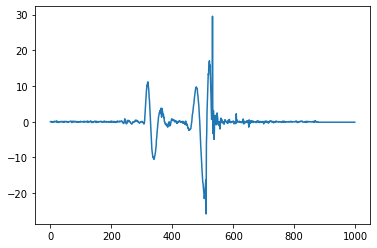

In [19]:
# Run simulation

# Choose input excitation
input_excitation = mechanical_components.AccelerometerInput(
    raw_accelerometer_input='../data/2021-03-05/D/log_03_acc.csv',
    accel_column='z_G',
    time_column='time(ms)',
    accel_unit='g',
    time_unit='ms',
    smooth=True,
    interpolate=True
)

import matplotlib.pyplot as plt
plt.plot(input_excitation.get_acceleration(np.linspace(0, 8, 1000)))

unified_model.mechanical_model.set_input(input_excitation)

In [20]:
# Run simulation
y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
unified_model.solve(t_start=0, t_end=8, y0=y0, t_eval=np.linspace(0, 8, 1000), t_max_step=1e-3)

In [21]:
results = unified_model.get_quick_results()
results.head()

,time,rel_pos_mag,rel_pos_vel,v_load
0,0.000000,0.032500,0.000000,0.0
1,0.008008,0.032486,-0.003359,0.0
2,0.016016,0.032447,-0.006288,0.0
3,0.024024,0.032387,-0.008640,0.0
4,0.032032,0.032311,-0.010312,0.0


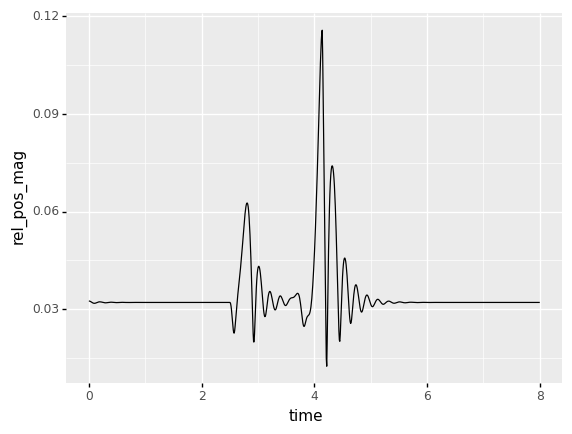

<ggplot: (-9223363258069728459)>


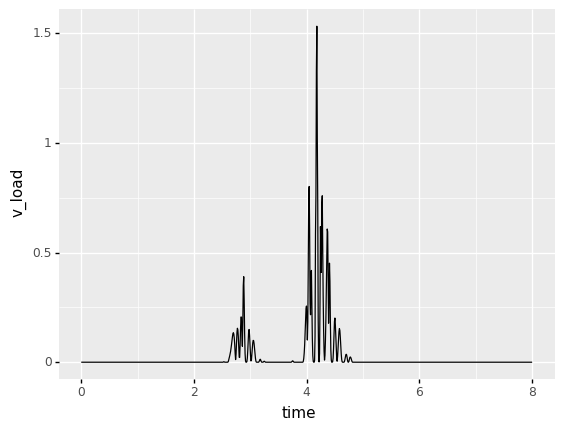

<ggplot: (-9223363258075442891)>


In [22]:
from plotnine import *
print(qplot('time', 'rel_pos_mag', results, geom='line'))
print(qplot('time', 'v_load', results, geom='line'))

In [23]:
def calculate_rms(arr):
    square = arr**2
    sum_square = np.sum(square)
    sqrt_sum_square = np.sqrt(sum_square / len(arr))
    return sqrt_sum_square

unified_model.calculate_metrics(prediction_expr='g(t, x5)', metric_dict={'rms': calculate_rms})

{'rms': 0.12047975983172521}